In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, 
                                   StratifiedKFold, cross_val_score)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_curve, auc, precision_recall_curve,
                           average_precision_score, confusion_matrix, 
                           classification_report)
from scipy.stats import randint, uniform, loguniform
import joblib
import pickle
import os
from datetime import datetime
import json

# MLflow imports
import mlflow
import mlflow.catboost
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [14]:
# Leggi i dati e le etichette dai file Parquet nella cartella preprocessed/binary/data_w_features
features_df_full = pd.read_parquet('processed_data/binary_classification/data_w_features/combined_features.parquet')
labels_df_full = pd.read_parquet('processed_data/binary_classification/data_w_features/labels_binary_stats_features_only.parquet')

# Campiona 10000 righe con distribuzione bilanciata tra le classi di labels_df per il training
n_samples_per_class = 20000  # 10000/2 per due classi
sampled_indices = (
    labels_df_full.groupby(labels_df_full.iloc[:, 0])
    .apply(lambda x: x.sample(n=n_samples_per_class, random_state=42))
    .index.get_level_values(1)
)
features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)

# Campiona 500000 righe con distribuzione bilanciata tra le classi di labels_df per il fit finale
n_samples_per_class = 250000  # 10000/2 per due classi
sampled_indices = (
    labels_df_full.groupby(labels_df_full.iloc[:, 0])
    .apply(lambda x: x.sample(n=n_samples_per_class, random_state=42))
    .index.get_level_values(1)
)
features_df_to_finalize = features_df_full.loc[sampled_indices].reset_index(drop=True)
labels_df_to_finalize = labels_df_full.loc[sampled_indices].reset_index(drop=True)

del features_df_full, labels_df_full, sampled_indices

In [19]:
class CatBoostPipeline:
    def __init__(self, features_df, labels_df, test_size=0.2, random_state=42, 
                 experiment_name="catboost_binary_classification", model_save_dir="./models"):
        """
        Inizializza la pipeline per CatBoost con integrazione MLflow
        
        Parameters:
        -----------
        features_df : pd.DataFrame
            DataFrame contenente le features
        labels_df : pd.DataFrame o pd.Series
            DataFrame/Series contenente le labels
        test_size : float
            Percentuale del dataset da usare per il test set
        random_state : int
            Seed per la riproducibilità
        experiment_name : str
            Nome dell'esperimento MLflow
        model_save_dir : str
            Directory dove salvare modelli e scaler
        """
        self.features_df = features_df
        self.labels_df = labels_df.values.ravel() if isinstance(labels_df, pd.DataFrame) else labels_df
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        self.best_params = None
        self.cv_results = None
        self.scaler = None
        
        # MLflow setup
        self.experiment_name = experiment_name
        self.model_save_dir = model_save_dir
        self.run_id = None
        
        # Crea directory per i modelli se non esiste
        os.makedirs(model_save_dir, exist_ok=True)
        
        # Setup MLflow experiment
        self._setup_mlflow_experiment()
        
    def _setup_mlflow_experiment(self):
        """Setup dell'esperimento MLflow"""
        try:
            # Verifica se l'esperimento esiste già
            experiment = mlflow.get_experiment_by_name(self.experiment_name)
            if experiment is None:
                mlflow.create_experiment(self.experiment_name)
            
            mlflow.set_experiment(self.experiment_name)
            print(f"✅ MLflow experiment '{self.experiment_name}' configurato correttamente")
            
        except Exception as e:
            print(f"⚠️  Errore nella configurazione MLflow: {e}")
            print("MLflow tracking sarà disabilitato")
            
    def _log_to_mlflow(self, key, value):
        """Helper per logging sicuro su MLflow"""
        try:
            if isinstance(value, (int, float)):
                mlflow.log_metric(key, value)
            else:
                mlflow.log_param(key, value)
        except Exception as e:
            print(f"⚠️  Errore nel logging MLflow per {key}: {e}")
            
    def prepare_data(self):
        """Prepara i dati dividendoli in train e test set"""
        print("=== PREPARAZIONE DATI ===")
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.features_df, self.labels_df, 
            test_size=self.test_size, 
            random_state=self.random_state,
            stratify=self.labels_df
        )
        
        # Normalizzazione delle features (opzionale per CatBoost ma può aiutare)
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Log info dataset su MLflow
        try:
            mlflow.log_param("dataset_total_samples", len(self.features_df))
            mlflow.log_param("train_samples", self.X_train.shape[0])
            mlflow.log_param("test_samples", self.X_test.shape[0])
            mlflow.log_param("n_features", self.X_train.shape[1])
            mlflow.log_param("test_size", self.test_size)
            mlflow.log_param("random_state", self.random_state)
            
            # Log distribuzione classi
            class_distribution = pd.Series(self.y_train).value_counts(normalize=True)
            for class_label, proportion in class_distribution.items():
                mlflow.log_metric(f"class_{class_label}_proportion", proportion)
                
        except Exception as e:
            print(f"⚠️  Errore nel logging dei dati: {e}")
        
        print("Dimensioni dataset:")
        print(f"Train set: {self.X_train.shape[0]} campioni")
        print(f"Test set: {self.X_test.shape[0]} campioni")
        print(f"Numero di features: {self.X_train.shape[1]}")
        print("\nDistribuzione classi nel training set:")
        print(pd.Series(self.y_train).value_counts(normalize=True))
        
    def hyperparameter_tuning(self, cv_folds=5, verbose=True, n_iter=250):
        """Ricerca degli iperparametri ottimali con logging MLflow"""
        print("\n=== HYPERPARAMETER TUNING ===")
        
        self.param_distributions = {
            'iterations': randint(100, 2000),
            'depth': randint(3, 12),
            'learning_rate': loguniform(0.01, 1.0),
            'l2_leaf_reg': loguniform(1, 100),
            'bagging_temperature': uniform(0.0, 1.0),
            'random_strength': uniform(0.0, 10.0),
            'one_hot_max_size': randint(2, 255),
            'max_ctr_complexity': randint(1, 8),
            'min_data_in_leaf': randint(1, 100),
            'leaf_estimation_iterations': randint(1, 20),
            'subsample': uniform(0.5, 0.5),  # 0.5 to 1.0
            'rsm': uniform(0.5, 0.5),  # 0.5 to 1.0
            'border_count': randint(32, 255),
            'feature_border_type': ['Median', 'Uniform', 'UniformAndQuantiles', 'MaxLogSum', 'MinEntropy', 'GreedyLogSum']
        }
        
        # Log parametri di ricerca su MLflow
        try:
            mlflow.log_param("cv_folds", cv_folds)
            mlflow.log_param("search_iterations", n_iter)
            mlflow.log_param("search_scoring", "roc_auc")
            
            # Log spazio di ricerca
            for param, distribution in self.param_distributions.items():
                if hasattr(distribution, 'args'):
                    mlflow.log_param(f"search_space_{param}", str(distribution.args))
                else:
                    mlflow.log_param(f"search_space_{param}", str(distribution))
                    
        except Exception as e:
            print(f"⚠️  Errore nel logging parametri di ricerca: {e}")
        
        # Modello base
        base_model = CatBoostClassifier(
            objective='Logloss',
            eval_metric='AUC',
            random_seed=self.random_state,
            verbose=False,
            thread_count=-1,
            allow_writing_files=False
        )
    
        # Stratified K-Fold
        stratified_kfold = StratifiedKFold(
            n_splits=cv_folds, 
            shuffle=True, 
            random_state=self.random_state
        )
        
        # RandomizedSearchCV
        self.grid_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=self.param_distributions,
            n_iter=n_iter,
            cv=stratified_kfold,
            scoring='roc_auc',
            n_jobs=6,
            verbose=2,
            random_state=self.random_state,
            return_train_score=True
        )
        
        # Esegui la ricerca
        print("Avvio ricerca iperparametri...")
        self.grid_search.fit(self.X_train_scaled, self.y_train)
        
        self.best_params = self.grid_search.best_params_
        self.cv_results = pd.DataFrame(self.grid_search.cv_results_)
        
        # Log risultati migliori su MLflow
        try:
            mlflow.log_metric("best_cv_score", self.grid_search.best_score_)
            
            # Log migliori parametri
            for param, value in self.best_params.items():
                mlflow.log_param(f"best_{param}", value)
                
            # Salva risultati CV completi
            cv_results_path = os.path.join(self.model_save_dir, "cv_results.csv")
            self.cv_results.to_csv(cv_results_path, index=False)
            mlflow.log_artifact(cv_results_path, "hyperparameter_search")
            
        except Exception as e:
            print(f"⚠️  Errore nel logging risultati: {e}")
        
        print("\nMigliori parametri trovati:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"\nMiglior score ROC-AUC (CV): {self.grid_search.best_score_:.4f}")
        
        # Visualizza i risultati della ricerca
        self._plot_hyperparameter_results()
        
    def train_final_model(self):
        """Addestra il modello finale con i migliori parametri"""
        print("\n=== ADDESTRAMENTO MODELLO FINALE ===")
        
        self.model = CatBoostClassifier(
            **self.best_params,
            objective='Logloss',
            eval_metric='AUC',
            random_seed=self.random_state,
            verbose=False,
            thread_count=-1,
            allow_writing_files=False
        )
        
        # Crea Pool per CatBoost (migliori performance)
        train_pool = Pool(self.X_train_scaled, self.y_train)
        test_pool = Pool(self.X_test_scaled, self.y_test)
        
        # Addestra con early stopping
        self.model.fit(
            train_pool,
            eval_set=test_pool,
            early_stopping_rounds=50,
            use_best_model=True
        )
        
        # Predizioni
        self.y_pred = self.model.predict(self.X_test_scaled)
        self.y_pred_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]
        
        # Calcola tutte le metriche
        metrics = {
            'accuracy': accuracy_score(self.y_test, self.y_pred),
            'precision': precision_score(self.y_test, self.y_pred),
            'recall': recall_score(self.y_test, self.y_pred),
            'f1_score': f1_score(self.y_test, self.y_pred),
            'roc_auc': auc(*roc_curve(self.y_test, self.y_pred_proba)[:2]),
            'average_precision': average_precision_score(self.y_test, self.y_pred_proba)
        }
        
        # Log metriche su MLflow
        try:
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"test_{metric_name}", metric_value)
                
            # Log numero di iterazioni utilizzate
            mlflow.log_metric("iterations_used", self.model.tree_count_)
            
        except Exception as e:
            print(f"⚠️  Errore nel logging metriche: {e}")
        
        # Stampa metriche
        print("\nMetriche sul test set:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
            
    def save_model_and_scaler(self, model_name=None):
        """Salva il modello addestrato e lo scaler"""
        print("\n=== SALVATAGGIO MODELLO E SCALER ===")
        
        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_name = f"catboost_model_{timestamp}"
        
        # Percorsi file
        model_path = os.path.join(self.model_save_dir, f"{model_name}.cbm")  # CatBoost format
        model_joblib_path = os.path.join(self.model_save_dir, f"{model_name}.joblib")  # Fallback
        scaler_path = os.path.join(self.model_save_dir, f"{model_name}_scaler.joblib")
        metadata_path = os.path.join(self.model_save_dir, f"{model_name}_metadata.json")
        
        try:
            # Salva modello (formato nativo CatBoost)
            self.model.save_model(model_path)
            print(f"✅ Modello salvato (CatBoost): {model_path}")
            
            # Salva anche in formato joblib per compatibilità
            joblib.dump(self.model, model_joblib_path)
            print(f"✅ Modello salvato (Joblib): {model_joblib_path}")
            
            # Salva scaler
            joblib.dump(self.scaler, scaler_path)
            print(f"✅ Scaler salvato: {scaler_path}")
            
            # Salva metadata
            metadata = {
                'model_name': model_name,
                'timestamp': datetime.now().isoformat(),
                'best_params': self.best_params,
                'cv_score': float(self.grid_search.best_score_),
                'test_metrics': {
                    'accuracy': float(accuracy_score(self.y_test, self.y_pred)),
                    'precision': float(precision_score(self.y_test, self.y_pred)),
                    'recall': float(recall_score(self.y_test, self.y_pred)),
                    'f1_score': float(f1_score(self.y_test, self.y_pred)),
                    'roc_auc': float(auc(*roc_curve(self.y_test, self.y_pred_proba)[:2]))
                },
                'feature_names': list(self.features_df.columns),
                'n_features': len(self.features_df.columns),
                'train_samples': len(self.y_train),
                'test_samples': len(self.y_test),
                'tree_count': int(self.model.tree_count_)
            }
            
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2)
            print(f"✅ Metadata salvati: {metadata_path}")
            
            # Log su MLflow
            try:
                # Log modello con MLflow (formato nativo CatBoost)
                signature = infer_signature(self.X_train_scaled, self.y_pred_proba)
                mlflow.catboost.log_model(
                    self.model, 
                    "catboost_model",
                    signature=signature
                )
                
                # Log scaler come artifact
                mlflow.log_artifact(scaler_path, "preprocessing")
                mlflow.log_artifact(metadata_path, "model_info")
                
                # Log paths come parametri
                mlflow.log_param("model_save_path", model_path)
                mlflow.log_param("scaler_save_path", scaler_path)
                mlflow.log_param("model_name", model_name)
                
                print("✅ Modello e scaler loggati su MLflow")
                
            except Exception as e:
                print(f"⚠️  Errore nel logging MLflow: {e}")
            
            return model_path, scaler_path, metadata_path
            
        except Exception as e:
            print(f"❌ Errore nel salvataggio: {e}")
            return None, None, None
    
    @staticmethod
    def load_model_and_scaler(model_path, scaler_path):
        """Carica modello e scaler salvati"""
        try:
            # Prova a caricare il modello CatBoost nativo
            if model_path.endswith('.cbm'):
                model = CatBoostClassifier()
                model.load_model(model_path)
            else:
                # Fallback a joblib
                model = joblib.load(model_path)
                
            scaler = joblib.load(scaler_path)
            print(f"✅ Modello caricato da: {model_path}")
            print(f"✅ Scaler caricato da: {scaler_path}")
            return model, scaler
        except Exception as e:
            print(f"❌ Errore nel caricamento: {e}")
            return None, None
    
    def predict_new_data(self, new_data, model_path=None, scaler_path=None):
        """Predice su nuovi dati usando il modello addestrato"""
        # Se i percorsi non sono forniti, usa il modello corrente
        if model_path and scaler_path:
            model, scaler = self.load_model_and_scaler(model_path, scaler_path)
        else:
            model, scaler = self.model, self.scaler
            
        if model is None or scaler is None:
            print("❌ Modello o scaler non disponibili")
            return None
        
        try:
            # Scala i nuovi dati
            new_data_scaled = scaler.transform(new_data)
            
            # Predizioni
            predictions = model.predict(new_data_scaled)
            probabilities = model.predict_proba(new_data_scaled)[:, 1]
            
            return predictions, probabilities
            
        except Exception as e:
            print(f"❌ Errore nella predizione: {e}")
            return None
    
    def finalize_model(self, features_df_to_finalize, labels_df_to_finalize, 
                      model_path, scaler_path, 
                      refit_scaler=True, use_early_stopping=True,
                      final_model_name=None, experiment_suffix="_finalized"):
        """
        Carica un modello esistente e lo riallena sui dati finali
        
        Parameters:
        -----------
        features_df_to_finalize : pd.DataFrame
            Nuove features per il training finale
        labels_df_to_finalize : pd.DataFrame o pd.Series
            Nuove labels per il training finale
        model_path : str
            Percorso del modello salvato da caricare
        scaler_path : str
            Percorso dello scaler salvato da caricare
        refit_scaler : bool
            Se True, rifatta lo scaler sui nuovi dati. Se False, usa la trasformazione esistente
        use_early_stopping : bool
            Se utilizzare early stopping durante il riallenaemnto
        final_model_name : str
            Nome per il modello finalizzato (se None, auto-generato)
        experiment_suffix : str
            Suffisso da aggiungere al nome dell'esperimento MLflow
            
        Returns:
        --------
        tuple: (final_model, final_scaler, run_id)
        """
        print("=== FINALIZZAZIONE MODELLO ===")
        
        # Prepara i dati finali
        labels_to_finalize = labels_df_to_finalize.values.ravel() if isinstance(labels_df_to_finalize, pd.DataFrame) else labels_df_to_finalize
        
        # Carica modello e scaler esistenti
        print(f"📂 Caricamento modello da: {model_path}")
        print(f"📂 Caricamento scaler da: {scaler_path}")
        
        base_model, base_scaler = self.load_model_and_scaler(model_path, scaler_path)
        if base_model is None or base_scaler is None:
            print("❌ Impossibile caricare modello o scaler")
            return None, None, None
        
        # Setup esperimento MLflow per finalizzazione
        original_experiment_name = self.experiment_name
        finalization_experiment_name = original_experiment_name + experiment_suffix
        
        try:
            experiment = mlflow.get_experiment_by_name(finalization_experiment_name)
            if experiment is None:
                mlflow.create_experiment(finalization_experiment_name)
            mlflow.set_experiment(finalization_experiment_name)
        except Exception as e:
            print(f"⚠️  Errore setup MLflow: {e}")
        
        # Avvia MLflow run per finalizzazione
        with mlflow.start_run() as run:
            finalization_run_id = run.info.run_id
            print(f"🚀 MLflow Finalization Run ID: {finalization_run_id}")
            
            try:
                # Log informazioni sulla finalizzazione
                mlflow.log_param("base_model_path", model_path)
                mlflow.log_param("base_scaler_path", scaler_path)
                mlflow.log_param("finalization_samples", len(features_df_to_finalize))
                mlflow.log_param("finalization_features", len(features_df_to_finalize.columns))
                mlflow.log_param("refit_scaler", refit_scaler)
                mlflow.log_param("use_early_stopping", use_early_stopping)
                
                # Log distribuzione classi nei dati finali
                class_distribution = pd.Series(labels_to_finalize).value_counts(normalize=True)
                for class_label, proportion in class_distribution.items():
                    mlflow.log_metric(f"final_class_{class_label}_proportion", proportion)
                
                print(f"📊 Dati finali: {len(features_df_to_finalize)} campioni, {len(features_df_to_finalize.columns)} features")
                print("Distribuzione classi nei dati finali:")
                print(pd.Series(labels_to_finalize).value_counts(normalize=True))
                
                # Gestione scaler
                if refit_scaler:
                    print("🔄 Riallenaemnto scaler sui nuovi dati...")
                    final_scaler = StandardScaler()
                    features_scaled = final_scaler.fit_transform(features_df_to_finalize)
                    mlflow.log_param("scaler_action", "refit_on_new_data")
                else:
                    print("📋 Utilizzo scaler esistente...")
                    final_scaler = base_scaler
                    features_scaled = final_scaler.transform(features_df_to_finalize)
                    mlflow.log_param("scaler_action", "use_existing")
                
                # Ottieni parametri del modello base
                base_params = base_model.get_params()
                print(f"🎯 Parametri modello base: {len(base_params)} parametri")
                
                # Log parametri del modello base
                for param, value in base_params.items():
                    if param not in ['random_seed', 'thread_count', 'objective', 'eval_metric', 'verbose', 'allow_writing_files']:
                        mlflow.log_param(f"base_{param}", value)
                
                # Crea nuovo modello con stessi parametri
                final_model = CatBoostClassifier(**base_params)
                
                # Training finale
                print("🚀 Avvio training finale...")
                
                if use_early_stopping and len(features_df_to_finalize) > 100:
                    # Se abbiamo abbastanza dati, usa una piccola porzione per validation
                    val_size = min(0.1, 100 / len(features_df_to_finalize))
                    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
                        features_scaled, labels_to_finalize,
                        test_size=val_size,
                        random_state=self.random_state,
                        stratify=labels_to_finalize
                    )
                    
                    # Crea Pool per CatBoost
                    train_pool = Pool(X_train_final, y_train_final)
                    val_pool = Pool(X_val_final, y_val_final)
                    
                    final_model.fit(
                        train_pool,
                        eval_set=val_pool,
                        early_stopping_rounds=50,
                        use_best_model=True
                    )
                    
                    mlflow.log_param("validation_split_used", True)
                    mlflow.log_param("validation_size", val_size)
                    
                    # Predizioni finali su validation set
                    y_val_pred = final_model.predict(X_val_final)
                    y_val_pred_proba = final_model.predict_proba(X_val_final)[:, 1]
                    
                    # Metriche finali
                    final_metrics = {
                        'final_accuracy': accuracy_score(y_val_final, y_val_pred),
                        'final_precision': precision_score(y_val_final, y_val_pred),
                        'final_recall': recall_score(y_val_final, y_val_pred),
                        'final_f1_score': f1_score(y_val_final, y_val_pred),
                        'final_roc_auc': auc(*roc_curve(y_val_final, y_val_pred_proba)[:2])
                    }
                    
                else:
                    # Training su tutti i dati senza early stopping
                    train_pool = Pool(features_scaled, labels_to_finalize)
                    final_model.fit(train_pool)
                    mlflow.log_param("validation_split_used", False)
                    
                    # Metriche sui dati di training (training accuracy)
                    y_train_pred = final_model.predict(features_scaled)
                    y_train_pred_proba = final_model.predict_proba(features_scaled)[:, 1]
                    
                    final_metrics = {
                        'final_train_accuracy': accuracy_score(labels_to_finalize, y_train_pred),
                        'final_train_precision': precision_score(labels_to_finalize, y_train_pred),
                        'final_train_recall': recall_score(labels_to_finalize, y_train_pred),
                        'final_train_f1_score': f1_score(labels_to_finalize, y_train_pred),
                        'final_train_roc_auc': auc(*roc_curve(labels_to_finalize, y_train_pred_proba)[:2])
                    }
                
                # Log metriche finali
                for metric_name, metric_value in final_metrics.items():
                    mlflow.log_metric(metric_name, metric_value)
                
                print("\n📈 Metriche finali:")
                for metric_name, metric_value in final_metrics.items():
                    print(f"  {metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
                
                # Confronto importanza features
                print("\n🔍 Analisi feature importance...")
                base_importance = pd.DataFrame({
                    'feature': features_df_to_finalize.columns,
                    'base_importance': base_model.feature_importances_
                }).sort_values('base_importance', ascending=False)
                
                final_importance = pd.DataFrame({
                    'feature': features_df_to_finalize.columns,
                    'final_importance': final_model.feature_importances_
                }).sort_values('final_importance', ascending=False)
                
                # Merge e analisi differenze
                importance_comparison = base_importance.merge(
                    final_importance, on='feature', how='inner'
                )
                importance_comparison['importance_change'] = (
                    importance_comparison['final_importance'] - importance_comparison['base_importance']
                )
                
                # Log top features che sono cambiate di più
                top_changes = importance_comparison.reindex(
                    importance_comparison['importance_change'].abs().sort_values(ascending=False).index
                ).head(10)
                
                print("Top 10 feature con maggiori cambiamenti in importanza:")
                try:
                    for _, row in top_changes.iterrows():
                        change_pct = (row['importance_change'] / (row['base_importance'] + 1e-8)) * 100
                        print(f"  {row['feature']}: {row['importance_change']:+.4f} ({change_pct:+.1f}%)")
                except Exception as e:
                    print(f"⚠️  Errore durante la stampa dei cambiamenti di importanza: {e}")
                
                # Salva modello e scaler finalizzati
                if final_model_name is None:
                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                    final_model_name = f"finalized_model_{timestamp}"
                
                final_model_path = os.path.join(self.model_save_dir, f"{final_model_name}.cbm")
                final_model_joblib_path = os.path.join(self.model_save_dir, f"{final_model_name}.joblib")
                final_scaler_path = os.path.join(self.model_save_dir, f"{final_model_name}_scaler.joblib")
                final_metadata_path = os.path.join(self.model_save_dir, f"{final_model_name}_metadata.json")
                importance_comparison_path = os.path.join(self.model_save_dir, f"{final_model_name}_importance_comparison.csv")
                
                # Salva tutto
                final_model.save_model(final_model_path)
                joblib.dump(final_model, final_model_joblib_path)
                joblib.dump(final_scaler, final_scaler_path)
                importance_comparison.to_csv(importance_comparison_path, index=False)
                
                # Metadata finali
                final_metadata = {
                    'model_name': final_model_name,
                    'finalization_timestamp': datetime.now().isoformat(),
                    'base_model_path': model_path,
                    'base_scaler_path': scaler_path,
                    'finalization_samples': len(features_df_to_finalize),
                    'finalization_features': len(features_df_to_finalize.columns),
                    'refit_scaler': refit_scaler,
                    'use_early_stopping': use_early_stopping,
                    'final_metrics': {k: float(v) for k, v in final_metrics.items()},
                    'model_params': {k: v for k, v in base_params.items() if k not in ['random_seed', 'thread_count']},
                    'feature_names': list(features_df_to_finalize.columns),
                    'class_distribution': {str(k): float(v) for k, v in class_distribution.items()},
                    'tree_count': int(final_model.tree_count_)
                }
                
                with open(final_metadata_path, 'w') as f:
                    json.dump(final_metadata, f, indent=2)
                
                # MLflow logging
                try:
                    # Log modello finalizzato
                    signature = infer_signature(features_scaled, final_model.predict_proba(features_scaled))
                    mlflow.catboost.log_model(
                        final_model, 
                        "finalized_catboost_model",
                        signature=signature
                    )
                    
                    # Log artifacts
                    mlflow.log_artifact(final_scaler_path, "preprocessing")
                    mlflow.log_artifact(final_metadata_path, "model_info")
                    mlflow.log_artifact(importance_comparison_path, "analysis")
                    
                    # Log parametri finali
                    mlflow.log_param("final_model_path", final_model_path)
                    mlflow.log_param("final_scaler_path", final_scaler_path)
                    mlflow.log_param("final_model_name", final_model_name)
                    
                    # Grafico confronto feature importance
                    fig, ax = plt.subplots(figsize=(12, 8))
                    top_15_comparison = importance_comparison.head(15)
                    
                    x = np.arange(len(top_15_comparison))
                    width = 0.35
                    
                    ax.bar(x - width/2, top_15_comparison['base_importance'], width, 
                          label='Modello Base', alpha=0.8)
                    ax.bar(x + width/2, top_15_comparison['final_importance'], width, 
                          label='Modello Finalizzato', alpha=0.8)
                    
                    ax.set_xlabel('Features')
                    ax.set_ylabel('Importance Score')
                    ax.set_title('Confronto Feature Importance: Base vs Finalizzato')
                    ax.set_xticks(x)
                    ax.set_xticklabels(top_15_comparison['feature'], rotation=45, ha='right')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    
                    # Salva e log grafico
                    plots_dir = os.path.join(self.model_save_dir, "finalization_plots")
                    os.makedirs(plots_dir, exist_ok=True)
                    comparison_plot_path = os.path.join(plots_dir, f"{final_model_name}_importance_comparison.png")
                    plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
                    mlflow.log_artifact(comparison_plot_path, "plots")
                    plt.show()
                    
                    print("✅ Artefatti salvati su MLflow")
                    
                except Exception as e:
                    print(f"⚠️  Errore nel logging MLflow: {e}")
                
                # Tag del run
                mlflow.set_tag("pipeline_status", "finalized")
                mlflow.set_tag("model_type", "catboost_finalized")
                mlflow.set_tag("base_model_source", model_path)
                
                print(f"\n=== FINALIZZAZIONE COMPLETATA ===")
                print(f"🎯 MLflow Run: {finalization_run_id}")
                print(f"💾 Modello finalizzato: {final_model_path}")
                print(f"⚙️  Scaler finalizzato: {final_scaler_path}")
                print(f"📊 Analisi importance: {importance_comparison_path}")
                
                # Aggiorna attributi della classe
                self.model = final_model
                self.scaler = final_scaler
                
                return final_model, final_scaler, finalization_run_id
                
            except Exception as e:
                mlflow.set_tag("pipeline_status", "failed")
                mlflow.log_param("error_message", str(e))
                print(f"❌ Errore nella finalizzazione: {e}")
                raise
                
        # Ripristina esperimento originale
        try:
            mlflow.set_experiment(original_experiment_name)
        except:
            pass
            
    def plot_all_visualizations(self):
        """Genera tutte le visualizzazioni e le salva su MLflow"""
        print("\n=== GENERAZIONE VISUALIZZAZIONI ===")
        
        try:
            # Crea directory temporanea per i grafici
            plots_dir = os.path.join(self.model_save_dir, "plots")
            os.makedirs(plots_dir, exist_ok=True)
            
            # 1. Feature Importance
            self._plot_feature_importance(save_dir=plots_dir)
            
            # 2. Curva ROC
            self._plot_roc_curve(save_dir=plots_dir)
            
            # 3. Curva Precision-Recall
            self._plot_pr_curve(save_dir=plots_dir)
            
            # 4. Matrice di Confusione
            self._plot_confusion_matrix(save_dir=plots_dir)
            
            # 5. Distribuzione delle probabilità predette
            self._plot_probability_distribution(save_dir=plots_dir)
            
            # 6. Learning Curves
            self._plot_learning_curves(save_dir=plots_dir)
            
            # 7. Calibration Plot
            self._plot_calibration_curve(save_dir=plots_dir)
            
            # 8. Classification Report Heatmap
            self._plot_classification_report(save_dir=plots_dir)
            
            # Log tutti i grafici su MLflow
            try:
                for plot_file in os.listdir(plots_dir):
                    if plot_file.endswith('.png'):
                        mlflow.log_artifact(os.path.join(plots_dir, plot_file), "plots")
                print("✅ Grafici salvati su MLflow")
            except Exception as e:
                print(f"⚠️  Errore nel logging grafici: {e}")
                
        except Exception as e:
            print(f"❌ Errore nella generazione grafici: {e}")
        
    def _plot_hyperparameter_results(self, save_dir=None):
        """Visualizza i risultati della ricerca degli iperparametri"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Convergenza durante la ricerca
        ax = axes[0, 0]
        ax.plot(range(len(self.cv_results)), self.cv_results['mean_test_score'])
        ax.axhline(y=self.grid_search.best_score_, color='r', linestyle='--', label='Best Score')
        ax.set_xlabel('Iterazione')
        ax.set_ylabel('ROC-AUC Score')
        ax.set_title('Convergenza della Grid Search')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Importanza relativa dei parametri
        ax = axes[0, 1]
        param_importance = {}
        for param in self.best_params.keys():
            col = f'param_{param}'
            if col in self.cv_results.columns:
                # Per parametri categorici, usiamo varianza
                if self.cv_results[col].dtype == 'object':
                    unique_vals = self.cv_results[col].nunique()
                    param_importance[param] = unique_vals / len(self.cv_results)
                else:
                    correlation = self.cv_results[[col, 'mean_test_score']].corr().iloc[0, 1]
                    if not np.isnan(correlation):
                        param_importance[param] = abs(correlation)
        
        if param_importance:
            pd.Series(param_importance).sort_values().plot(kind='barh', ax=ax)
            ax.set_title('Importanza Relativa dei Parametri')
            ax.set_xlabel('Score di Importanza')
        
        # 3. Distribuzione dei migliori score
        ax = axes[1, 0]
        ax.hist(self.cv_results['mean_test_score'], bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(self.grid_search.best_score_, color='red', linestyle='--', 
                  label=f'Best: {self.grid_search.best_score_:.4f}')
        ax.set_xlabel('ROC-AUC Score')
        ax.set_ylabel('Frequenza')
        ax.set_title('Distribuzione degli Score CV')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Tempo di training vs performance
        ax = axes[1, 1]
        if 'mean_fit_time' in self.cv_results.columns:
            scatter = ax.scatter(self.cv_results['mean_fit_time'], 
                               self.cv_results['mean_test_score'],
                               c=self.cv_results['mean_test_score'],
                               cmap='viridis', alpha=0.6)
            ax.set_xlabel('Tempo di Training (secondi)')
            ax.set_ylabel('ROC-AUC Score')
            ax.set_title('Trade-off Tempo vs Performance')
            plt.colorbar(scatter, ax=ax)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'hyperparameter_results.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_feature_importance(self, save_dir=None):
        """Visualizza l'importanza delle features"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. CatBoost feature importance
        ax = axes[0]
        feature_importance = pd.DataFrame({
            'feature': self.features_df.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False).head(20)
        
        sns.barplot(data=feature_importance, x='importance', y='feature', ax=ax)
        ax.set_title('Top 20 Features più Importanti')
        ax.set_xlabel('Importance Score')
        
        # 2. CatBoost object importance (se disponibile)
        ax = axes[1]
        try:
            # Prova a ottenere l'object importance di CatBoost
            obj_importance = self.model.get_feature_importance(prettified=True)
            if len(obj_importance) > 0:
                top_obj_importance = obj_importance.head(15)
                sns.barplot(data=top_obj_importance, x='Importances', y='Feature Id', ax=ax)
                ax.set_title('Top 15 Features (Object Importance)')
            else:
                # Fallback: mostra solo le top 15 normali
                top_15 = feature_importance.head(15)
                sns.barplot(data=top_15, x='importance', y='feature', ax=ax)
                ax.set_title('Top 15 Features più Importanti')
        except:
            # Fallback: mostra solo le top 15 normali
            top_15 = feature_importance.head(15)
            sns.barplot(data=top_15, x='importance', y='feature', ax=ax)
            ax.set_title('Top 15 Features più Importanti')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'feature_importance.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_roc_curve(self, save_dir=None):
        """Visualizza la curva ROC"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot della curva ROC
        ax.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        
        # Trova il punto ottimale
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
                  label=f'Optimal point (threshold={optimal_threshold:.3f})')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'roc_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_pr_curve(self, save_dir=None):
        """Visualizza la curva Precision-Recall"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_pred_proba)
        average_precision = average_precision_score(self.y_test, self.y_pred_proba)
        
        # Plot della curva PR
        ax.plot(recall, precision, color='blue', lw=2,
                label=f'PR curve (AP = {average_precision:.3f})')
        
        # Baseline (proporzione della classe positiva)
        baseline = np.sum(self.y_test) / len(self.y_test)
        ax.axhline(y=baseline, color='red', linestyle='--', 
                  label=f'Baseline (Random) = {baseline:.3f}')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend(loc="lower left")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_confusion_matrix(self, save_dir=None):
        """Visualizza la matrice di confusione"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        cm = confusion_matrix(self.y_test, self.y_pred)
        
        # 1. Matrice di confusione con valori assoluti
        ax = axes[0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix - Valori Assoluti')
        
        # 2. Matrice di confusione normalizzata
        ax = axes[1]
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix - Normalizzata per Riga')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_probability_distribution(self, save_dir=None):
        """Visualizza la distribuzione delle probabilità predette"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # 1. Istogramma delle probabilità per classe
        ax = axes[0]
        ax.hist(self.y_pred_proba[self.y_test == 0], bins=50, alpha=0.5, 
                label='Classe 0', color='blue', density=True)
        ax.hist(self.y_pred_proba[self.y_test == 1], bins=50, alpha=0.5, 
                label='Classe 1', color='red', density=True)
        ax.axvline(x=0.5, color='black', linestyle='--', label='Threshold=0.5')
        ax.set_xlabel('Probabilità Predetta')
        ax.set_ylabel('Densità')
        ax.set_title('Distribuzione delle Probabilità per Classe')
        ax.legend()
        
        # 2. Box plot delle probabilità
        ax = axes[1]
        data_to_plot = [self.y_pred_proba[self.y_test == 0], 
                       self.y_pred_proba[self.y_test == 1]]
        ax.boxplot(data_to_plot, labels=['Classe 0', 'Classe 1'])
        ax.set_ylabel('Probabilità Predetta')
        ax.set_title('Box Plot delle Probabilità per Classe')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'probability_distribution.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_learning_curves(self, save_dir=None):
        """Visualizza le learning curves"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        try:
            # Prova a ottenere i metricsd i evaluation da CatBoost
            evals_result = self.model.get_evals_result()
            
            if evals_result and 'learn' in evals_result:
                # Estrai metriche di training
                if 'AUC' in evals_result['learn']:
                    train_auc = evals_result['learn']['AUC']
                    epochs = range(len(train_auc))
                    ax.plot(epochs, train_auc, label='Train AUC', color='blue')
                
                # Estrai metriche di validation se disponibili
                if 'validation' in evals_result and 'AUC' in evals_result['validation']:
                    val_auc = evals_result['validation']['AUC']
                    epochs = range(len(val_auc))
                    ax.plot(epochs, val_auc, label='Validation AUC', color='orange')
                
                ax.set_xlabel('Iterazione')
                ax.set_ylabel('AUC Score')
                ax.set_title('Learning Curves - AUC durante il Training')
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                # Fallback: mostra un messaggio
                ax.text(0.5, 0.5, 'Learning curves non disponibili\n(modello non trainato con eval_set)', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_title('Learning Curves')
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Errore nel recupero learning curves:\n{str(e)}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_title('Learning Curves')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'learning_curves.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_calibration_curve(self, save_dir=None):
        """Visualizza la curva di calibrazione"""
        from sklearn.calibration import calibration_curve
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Calcola la curva di calibrazione
        fraction_of_positives, mean_predicted_value = calibration_curve(
            self.y_test, self.y_pred_proba, n_bins=10
        )
        
        # Plot
        ax.plot(mean_predicted_value, fraction_of_positives, 's-', label='CatBoost')
        ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
        
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title('Calibration Plot (Reliability Diagram)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'calibration_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_classification_report(self, save_dir=None):
        """Visualizza il classification report come heatmap"""
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Genera il classification report
        report = classification_report(self.y_test, self.y_pred, output_dict=True)
        
        # Converti in DataFrame per la visualizzazione
        df_report = pd.DataFrame(report).transpose()
        df_report = df_report.iloc[:-1, :-1]  # Rimuovi 'accuracy' e 'support'
        
        # Heatmap
        sns.heatmap(df_report, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax)
        ax.set_title('Classification Report Heatmap')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'classification_report.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def run_complete_pipeline(self, model_name=None):
        """Esegue l'intera pipeline con MLflow tracking"""
        print("=== AVVIO PIPELINE COMPLETA ===\n")
        
        # Avvia MLflow run
        with mlflow.start_run() as run:
            self.run_id = run.info.run_id
            print(f"🚀 MLflow Run ID: {self.run_id}")
            
            try:
                # 1. Preparazione dati
                self.prepare_data()
                
                # 2. Ricerca iperparametri
                self.hyperparameter_tuning()
                
                # 3. Training modello finale
                self.train_final_model()
                
                # 4. Salvataggio modello e scaler
                model_path, scaler_path, metadata_path = self.save_model_and_scaler(model_name)
                
                # 5. Visualizzazioni
                self.plot_all_visualizations()
                
                # 6. Tag del run
                mlflow.set_tag("pipeline_status", "completed")
                mlflow.set_tag("model_type", "catboost_binary_classifier")
                
                print("\n=== PIPELINE COMPLETATA ===")
                print(f"🎯 MLflow Run: {self.run_id}")
                print(f"💾 Modello salvato: {model_path}")
                print(f"⚙️  Scaler salvato: {scaler_path}")
                
                return self.model, self.best_params, self.run_id
                
            except Exception as e:
                mlflow.set_tag("pipeline_status", "failed")
                mlflow.log_param("error_message", str(e))
                print(f"❌ Errore nella pipeline: {e}")
                raise

✅ MLflow experiment 'catboost_experiment_110625_1853' configurato correttamente
=== AVVIO PIPELINE COMPLETA ===

🚀 MLflow Run ID: 2e6fae57db934024b270fa4c3fec0a1e
=== PREPARAZIONE DATI ===
Dimensioni dataset:
Train set: 32000 campioni
Test set: 8000 campioni
Numero di features: 134

Distribuzione classi nel training set:
0    0.5
1    0.5
Name: proportion, dtype: float64

=== HYPERPARAMETER TUNING ===
Avvio ricerca iperparametri...
Fitting 5 folds for each of 250 candidates, totalling 1250 fits

Migliori parametri trovati:
  bagging_temperature: 0.12188609333694755
  border_count: 234
  depth: 9
  feature_border_type: MaxLogSum
  iterations: 1709
  l2_leaf_reg: 39.770604379101265
  leaf_estimation_iterations: 7
  learning_rate: 0.03895440529016967
  max_ctr_complexity: 1
  min_data_in_leaf: 42
  one_hot_max_size: 190
  random_strength: 2.5656278370136376
  rsm: 0.9814634376187898
  subsample: 0.7417728233599623

Miglior score ROC-AUC (CV): 0.9183


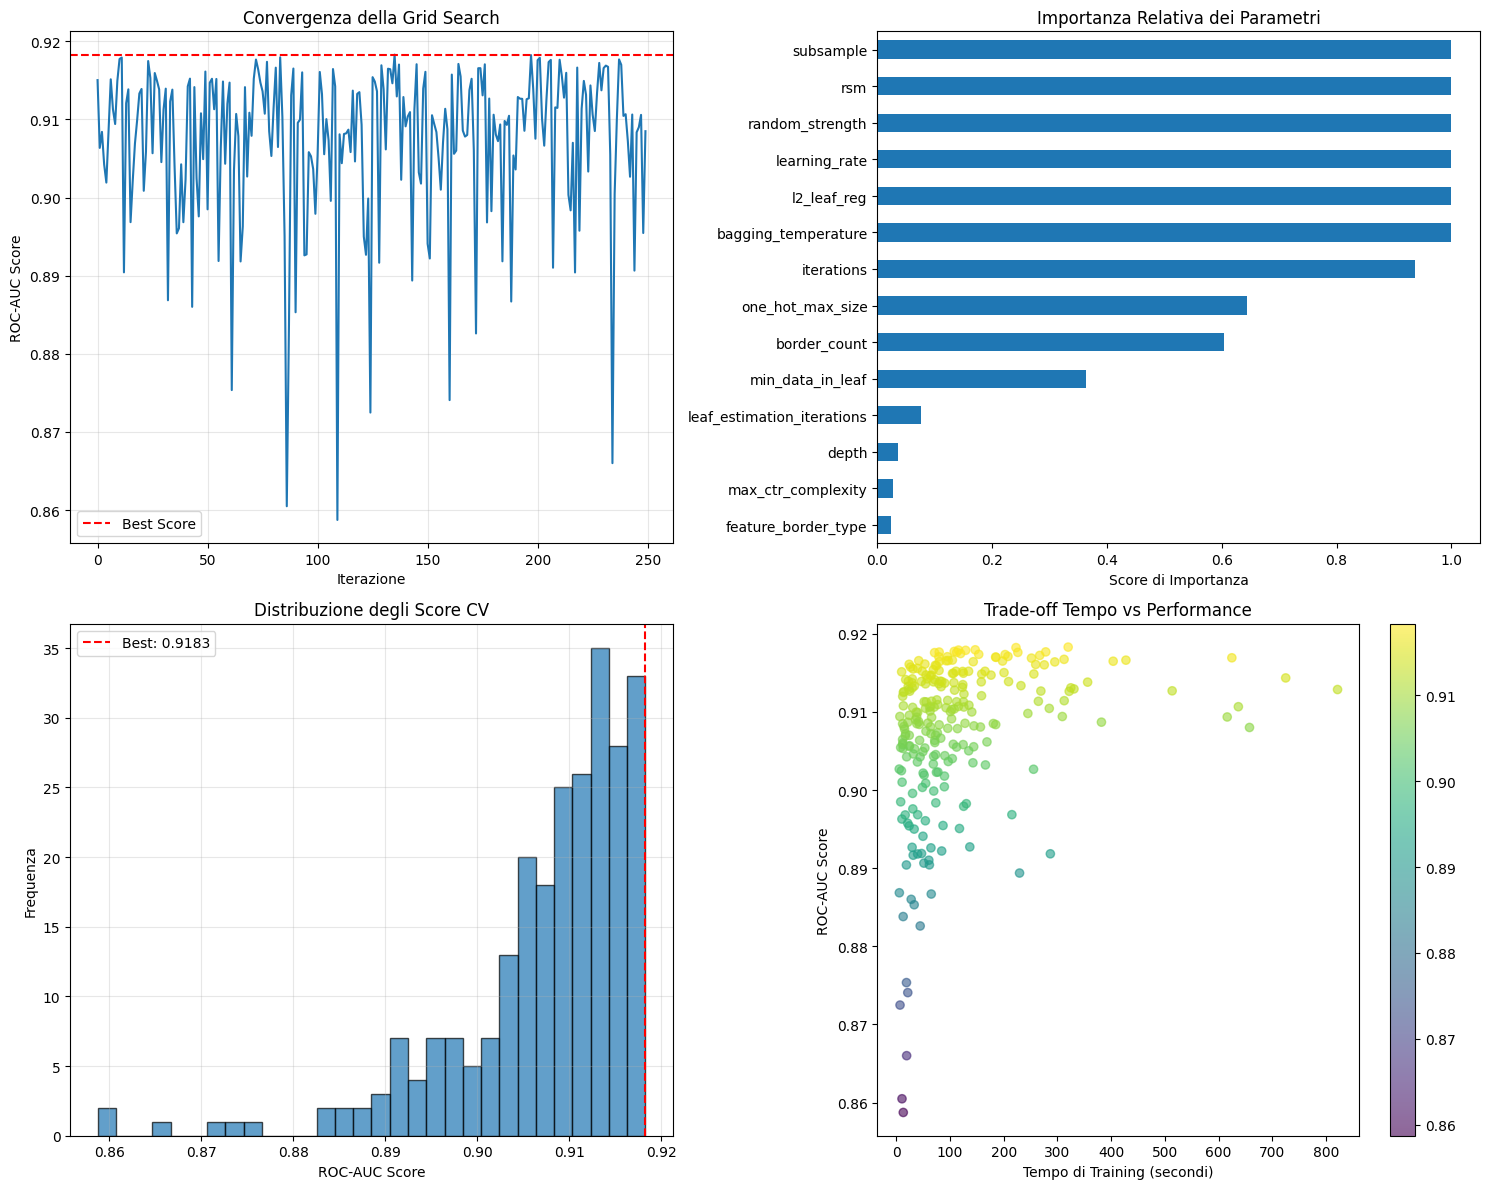


=== ADDESTRAMENTO MODELLO FINALE ===


2025/06/12 01:38:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Metriche sul test set:
Accuracy: 0.8465
Precision: 0.8247
Recall: 0.8800
F1 Score: 0.8515
Roc Auc: 0.9213
Average Precision: 0.9147

=== SALVATAGGIO MODELLO E SCALER ===
✅ Modello salvato (CatBoost): ./models\catboost_dev_model_v1.cbm
✅ Modello salvato (Joblib): ./models\catboost_dev_model_v1.joblib
✅ Scaler salvato: ./models\catboost_dev_model_v1_scaler.joblib
✅ Metadata salvati: ./models\catboost_dev_model_v1_metadata.json
✅ Modello e scaler loggati su MLflow

=== GENERAZIONE VISUALIZZAZIONI ===


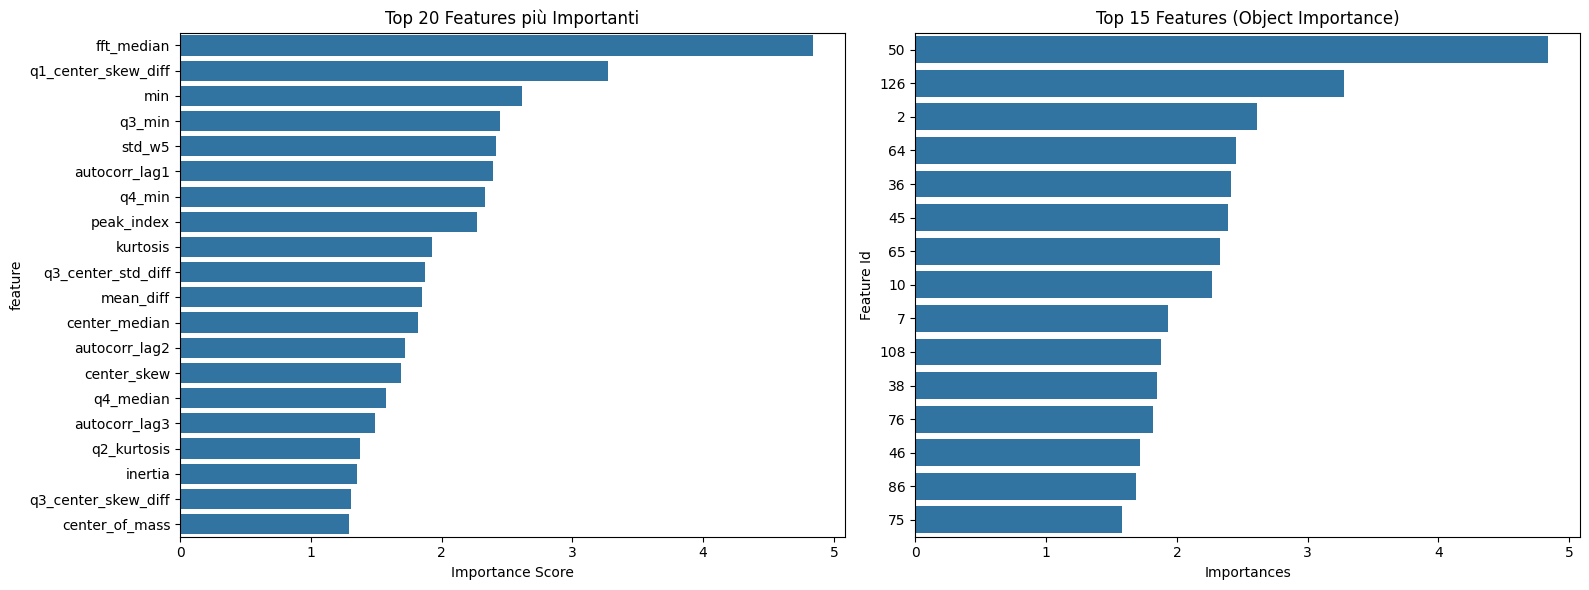

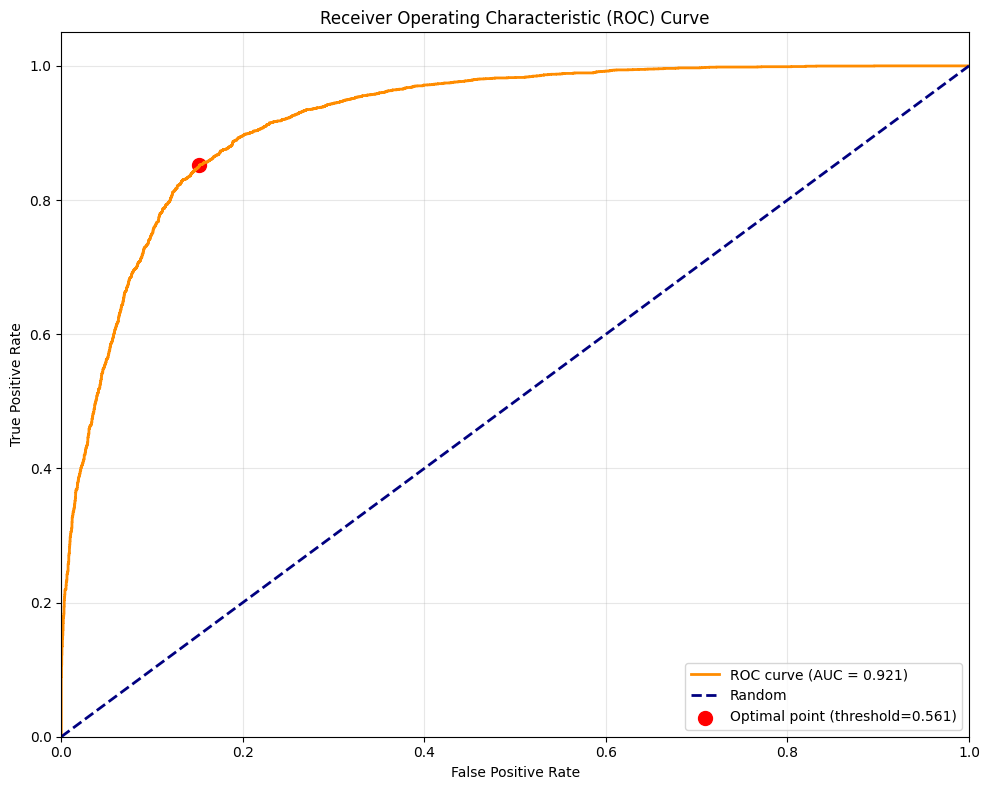

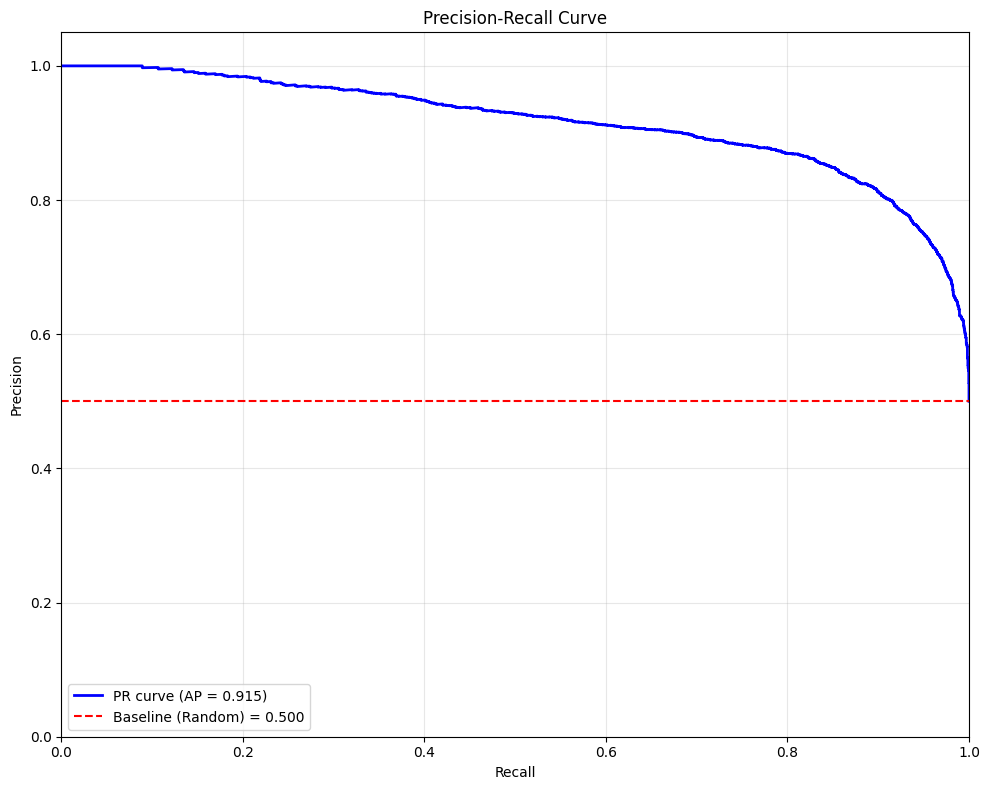

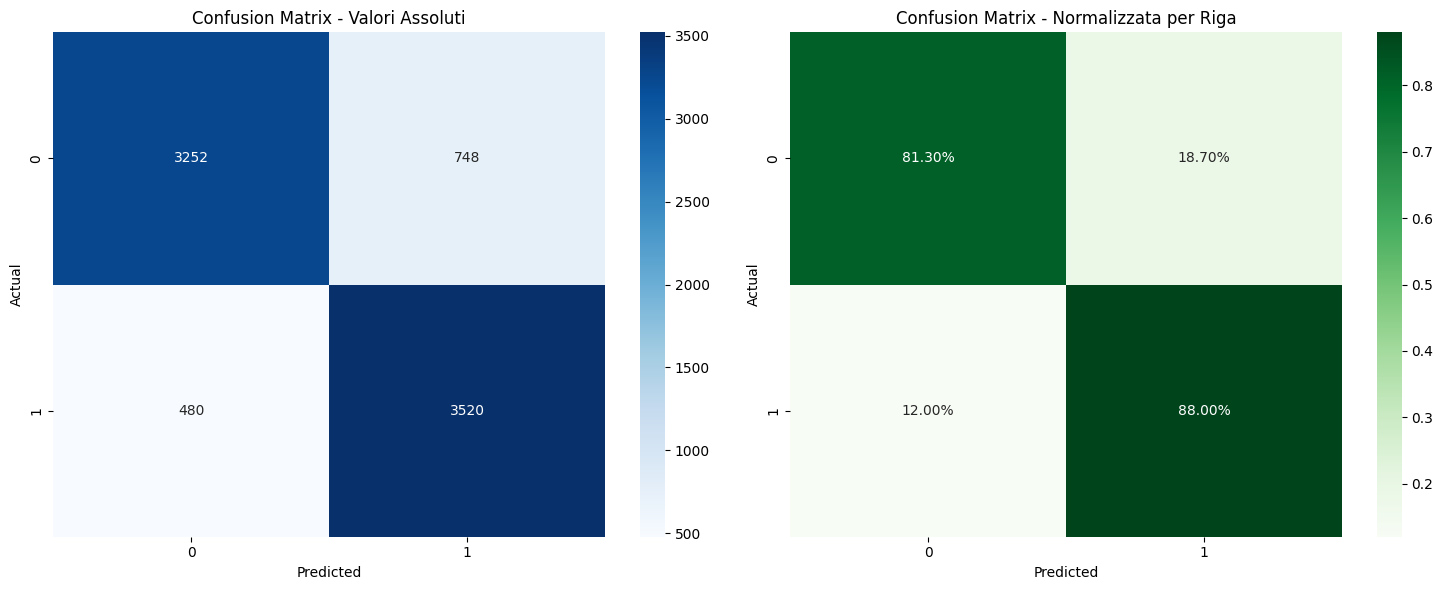

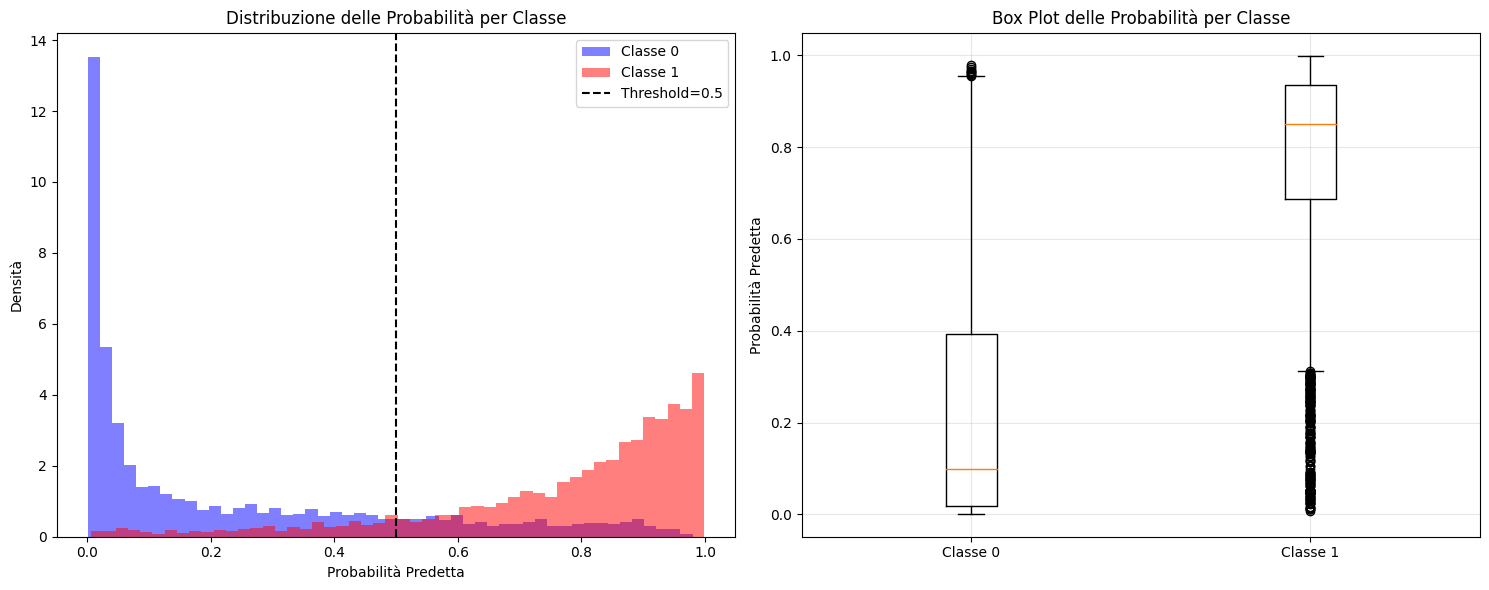

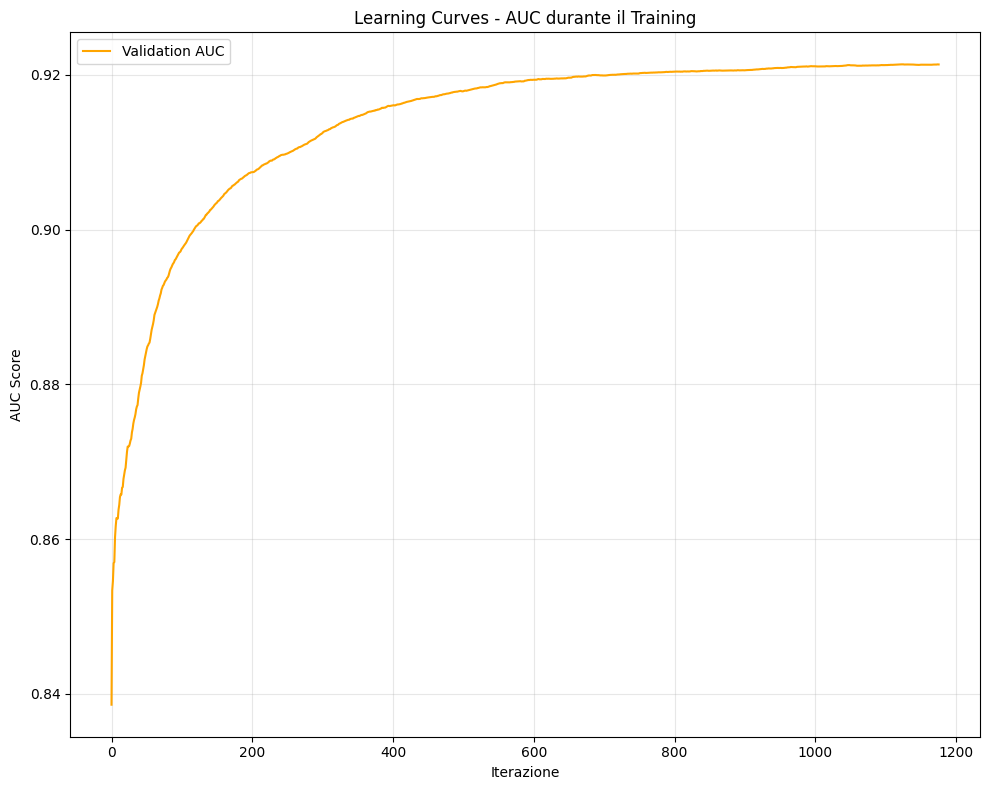

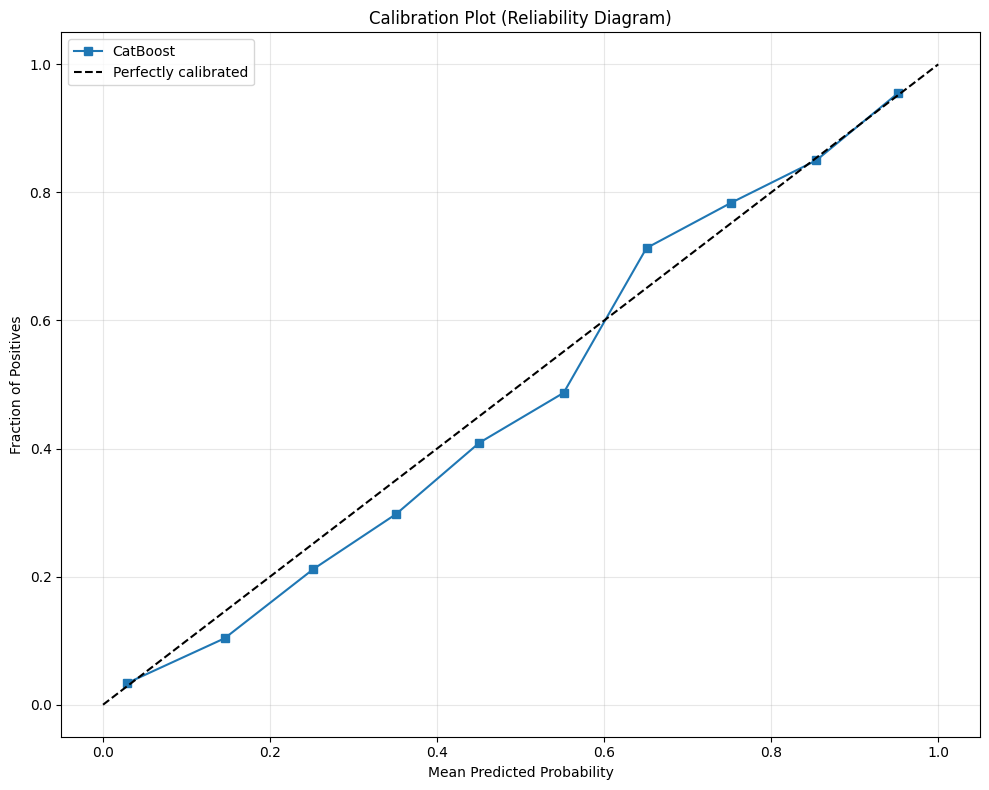

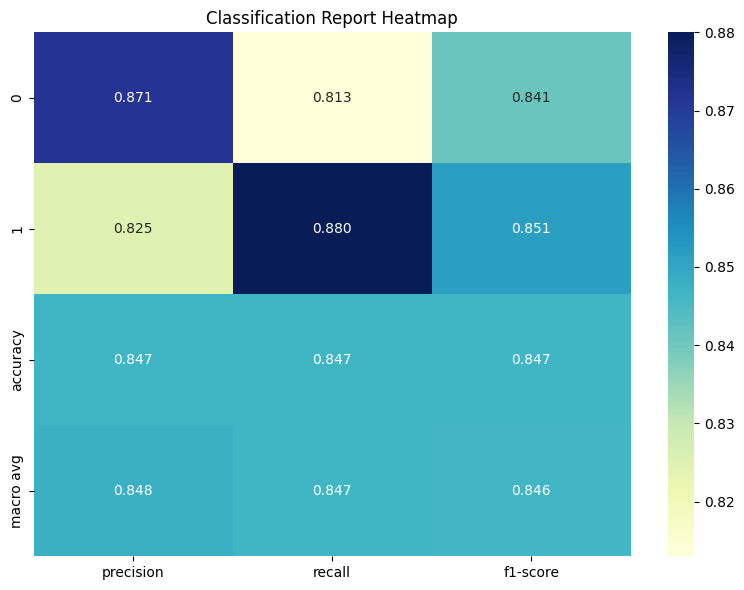

✅ Grafici salvati su MLflow

=== PIPELINE COMPLETATA ===
🎯 MLflow Run: 2e6fae57db934024b270fa4c3fec0a1e
💾 Modello salvato: ./models\catboost_dev_model_v1.cbm
⚙️  Scaler salvato: ./models\catboost_dev_model_v1_scaler.joblib


In [16]:
date = datetime.now().strftime("%d%m%y_%H%M")
pipeline = CatBoostPipeline(
    features_df=features_df, 
    labels_df=labels_df,
    experiment_name=f"catboost_experiment_{date}",
    model_save_dir="./models"
)

# Esegui la pipeline completa
model, best_params, run_id = pipeline.run_complete_pipeline(
    model_name="catboost_dev_model_v1"
)

In [ ]:
# Finalizza il modello sui dati completi
final_model, final_scaler, final_run_id = pipeline.finalize_model(
     features_df_to_finalize=features_df_to_finalize,
     labels_df_to_finalize=labels_df_to_finalize,
     model_path="./models/catboost_dev_model_v1.cbm",
     scaler_path="./models/catboost_dev_model_v1_scaler.joblib",
     refit_scaler=True,  # Riallena scaler sui dati finali
     final_model_name="catboost_trained_on_full_data_model_v1"
 )


=== FINALIZZAZIONE MODELLO ===
📂 Caricamento modello da: ./models/catboost_dev_model_v1.cbm
📂 Caricamento scaler da: ./models/catboost_dev_model_v1_scaler.joblib
✅ Modello caricato da: ./models/catboost_dev_model_v1.cbm
✅ Scaler caricato da: ./models/catboost_dev_model_v1_scaler.joblib
🚀 MLflow Finalization Run ID: d536b822e45d4b45b4f9f667d9a12fd3
📊 Dati finali: 500000 campioni, 134 features
Distribuzione classi nei dati finali:
0    0.5
1    0.5
Name: proportion, dtype: float64
🔄 Riallenaemnto scaler sui nuovi dati...
🎯 Parametri modello base: 22 parametri
🚀 Avvio training finale...

📈 Metriche finali:
  Final Accuracy: 0.7800
  Final Precision: 0.7333
  Final Recall: 0.8800
  Final F1 Score: 0.8000
  Final Roc Auc: 0.8868

🔍 Analisi feature importance...
Top 10 feature con maggiori cambiamenti in importanza:
❌ Errore nella finalizzazione: unsupported operand type(s) for +: 'NoneType' and 'float'


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [ ]:

# ========================================
# SCENARIO 3: Predizioni con modello salvato
# ========================================

# Per predire su nuovi dati
# new_predictions, new_probabilities = pipeline.predict_new_data(new_data_df)

# Per caricare un modello salvato
# model, scaler = CatBoostPipeline.load_model_and_scaler(
#     "./my_models/production_model_v1.cbm", 
#     "./my_models/production_model_v1_scaler.joblib"
# )

# ========================================
# SCENARIO 4: Workflow completo dev->prod
# ========================================

def complete_dev_to_prod_workflow():
    """Esempio di workflow completo da sviluppo a produzione"""
    
    # 1. Sviluppo su subset dei dati
    dev_pipeline = CatBoostPipeline(
        features_df=dev_features,
        labels_df=dev_labels,
        experiment_name="model_development",
        model_save_dir="./models"
    )
    
    dev_model, dev_params, dev_run = dev_pipeline.run_complete_pipeline(
        model_name="dev_model_v1"
    )
    
    # 2. Finalizzazione su dataset completo
    prod_model, prod_scaler, prod_run = dev_pipeline.finalize_model(
        features_df_to_finalize=full_features,
        labels_df_to_finalize=full_labels,
        model_path="./models/dev_model_v1.cbm",
        scaler_path="./models/dev_model_v1_scaler.joblib",
        final_model_name="production_model_final"
    )
    
    # 3. Test finale
    test_predictions, test_probabilities = dev_pipeline.predict_new_data(test_features)
    
    return prod_model, prod_scaler, test_predictions

